# Spark Group D Assigment
### An analysis on the U.S. states with relations to the time of departure and arrival to the respective airports (given the 'Flights Dataset', discussed in class).

### Authors
 - Sandra Alemayehu
 - Frederico Andrade
 - Fernando Llopis
 - Amritesh Palani
 - Carmen Roldan
 - Bibake Uppal

In [1]:
import findspark
findspark.init()

In [2]:
findspark.find()
import pyspark
findspark.find()

'/opt/spark-2.4.4-bin-hadoop2.7'

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = pyspark.SparkConf().setAppName('appName').setMaster('local[4]')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [37]:
#pip install pandas
#pip install matplotlib

import pyspark.sql.functions as F
from pyspark.sql.functions import when
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from pyspark.sql.types import IntegerType


display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width

# Introduction 

This notebook aims to offer insight into the relationship between a state's economic and sociologic traits, and its air travel patters. With this information, state governments can work with airports to optimize a variety of relevant metrics. Though what consitutes relevant may differ from situation to situation, the analysis done here will likley be of value to governments and airports.

The questions answered in this report include:

1. Is there a relation between the economic prosperity of a state and the proportion of flights that arrive to it during the weekdays or weekends?
2. Is there any relation between the business nature of a state and the proportion of flights that arrive early in the morning (e.g. with people in a business travel) with respect to the number of flights arriving during the rest of the day?
3. Is this proportion between flights arriving in the morning and the afternoon much different if we compare weekdays vs weekends in those states?
4. Are there states that receive most flights at weekends? Is this typical of a vacation states?
5. Can we say more developed states suffer from smaller arrival delays on average?
6. Is there a relation between the arrival time and the arrival delay? Is the relation the same for all categories of states?
7. Is there a relation between the departure time and the departure delay? Is the relation the same for all categories of states?

In order to conduct this analysis, two primary datasets were used:

- 2008 Flight Dataset
- 2008 State-Level Economic Dataset

These two datasets are described in more detail below.

# Data Prep 

## 2008 Flights Dataset

The flights dataset comes from the U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS)

This dataset is composed by the following variables:

1. **Year** 2008
2. **Month** 1
3. **DayofMonth** 1-31
4. **DayOfWeek** 1 (Monday) - 7 (Sunday)
5. **DepTime** actual departure time (local, hhmm)
6. **CRSDepTime** scheduled departure time (local, hhmm)
7. **ArrTime** actual arrival time (local, hhmm)
8. **CRSArrTime** scheduled arrival time (local, hhmm)
9. **UniqueCarrie**r unique carrier code
10. **FlightNum** flight number
11. **TailNum** plane tail number: aircraft registration, unique aircraft identifier
12. **ActualElapsedTime** in minutes
13. **CRSElapsedTime** in minutes
14. **AirTime** in minutes
15. **ArrDelay** arrival delay, in minutes: A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS).
16. **DepDelay** departure delay, in minutes
17. **Origin** origin IATA airport code
18. **Dest** destination IATA airport code
19. **Distance** in miles
20. **TaxiIn** taxi in time, in minutes
21. **TaxiOut** taxi out time in minutes
22. **Cancelled** *was the flight cancelled
23. **CancellationCode** reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24. **Diverted** 1 = yes, 0 = no
25. **CarrierDelay** in minutes: Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
26. **WeatherDelay** in minutes: Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.
27. **NASDelay** in minutes: Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc.
28. **SecurityDelay** in minutes: Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
29. **LateAircraftDelay** in minutes: Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation
30. **State** all 50 states of the United States.
31. **Population** integer: total population of each state.
32. **GDP per capita** integer: total gdp per capita for each state.
33. **Unemployment rate** float: percentage of unemployment accross each state.
34. **Poverty** integer: poverty rates for each state.
35. **Agriculture** 
36. **Services**
37. **Construction**
38. **Financial Services**
39. **Technology**
40. **Industry**
41. **Travelling and Tourism**

### Preparing data

Here, we read in the data and prepare the dataset to be used for the analysis.

In [5]:
Flights08 = spark.read\
                 .option("header", "true")\
                 .option("inferSchema", "true")\
                 .csv("flights_jan08.csv")

The code below is meant to enrich the flights dataset with the state code associated with each airport. This is important for merging the dataset with the state-level economics dataset described in the following section.

In [6]:
airports = spark.read\
                .option("header", "true")\
                .option("inferSchema", "true")\
                .csv("airports.csv")

airports_clean = airports.where((F.col("iso_country") == 'US') & (F.col("iata_code").isNotNull()))\
                   .withColumn('state', F.col('iso_region').substr(4,10))\
                   .select("iata_code", 'state')

flightsDF = Flights08.join(airports_clean, Flights08.Origin == airports_clean.iata_code, how = 'left')\
                     .withColumnRenamed("state", 'Origin_state')\
                     .drop("iata_code")\
                     .join(airports_clean, Flights08.Dest == airports_clean.iata_code, how = 'left')\
                     .withColumnRenamed("state", 'Dest_state')\
                     .drop("iata_code")\
                     .withColumn("ArrTime",F.col("ArrTime").cast(IntegerType()))\
                     .withColumn("DepTime",F.col("DepTime").cast(IntegerType()))\
                     .withColumn("ArrDelay",F.col("ArrDelay").cast(IntegerType()))\
                     .withColumn("DepDelay",F.col("DepDelay").cast(IntegerType()))\
                     .cache()

flightsDF.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-

## 2008 State-Level Economic Dataset

A variety of sources were used to create the State-Level Economic Dataset used throughout the analysis. The dataset includes the following information:

- **State**, which is the name of the state
- **Population** the population of the state in 2008
- **GDP per capita** for the state in 2008
- **Unemployment Rate**
- **Poverty** level

Data regarding the amount of contribution to GDP from various sectors:
- **Agriculture**
- **Services**
- **Construction**
- **Financial activities**
- **Technology**
- **Industry**
- **Travel and tourism**

### Preparing data

Here, we read in the data and prepare the dataset to be used for the analysis.

In [7]:
# https://ssti.org/blog/useful-stats-capita-gdp-state-2008-2017

states08 = spark.read\
                .option("header", "true")\
                .option("sep", ";")\
                .option("inferSchema", "true")\
                .csv("economic_data.csv")

The dataset is enriched with state codes, which will allow for merging with the flights dataset, and GDP, which is simply a product of GDP per capita and population.

In [8]:
# Source: https://data.world/uscensusbureau/fips-state-codes

state_codes = spark.createDataFrame(pd.read_csv('https://query.data.world/s/jwcnjqlganbi5nbnmn7pnqegyjzhfl'))

state_codes_clean = state_codes.select('STUSAB', 'STATE_NAME')\
                               .withColumnRenamed("STUSAB", 'STATE_CODE')

statesDF = states08.join(state_codes_clean, states08.State == state_codes_clean.STATE_NAME, how = 'left')\
                   .drop('STATE_NAME')\
                   .withColumn("GDP", (F.col("GDP per capita") * F.col("Population")))\
                   .cache()

statesDF.printSchema()

root
 |-- State: string (nullable = true)
 |-- Population: integer (nullable = true)
 |-- GDP per capita: integer (nullable = true)
 |-- Unemployment Rate: double (nullable = true)
 |-- Poverty: integer (nullable = true)
 |-- Agriculture: integer (nullable = true)
 |-- Services: integer (nullable = true)
 |-- Construction: integer (nullable = true)
 |-- Financial activities: integer (nullable = true)
 |-- Technology: integer (nullable = true)
 |-- Industry: integer (nullable = true)
 |-- Travelling and turism: integer (nullable = true)
 |-- STATE_CODE: string (nullable = true)
 |-- GDP: integer (nullable = true)



In [9]:
print("The January Flights 2008 DataFrame has {} rows.".format(flightsDF.count()))
print("The United States 2008 DataFrame has {} rows.".format(statesDF.count()))

The January Flights 2008 DataFrame has 100000 rows.
The United States 2008 DataFrame has 51 rows.


# Analysis

## 1. Is there a relation between the economic prosperity of a state and the proportion of flights that arrive to it during the weekdays or weekends?

To answer this question, we must compute the percentage of flights on weekends and weekdays, and merge that information with economic information.

Prior to doing so, we check the relevant columns in the states dataframe.

In [10]:
statesDF.select("STATE_CODE", "State", 'GDP per capita', 'Population',"GDP")\
        .show(55)

+----------+--------------------+--------------+----------+-----------+
|STATE_CODE|               State|GDP per capita|Population|        GDP|
+----------+--------------------+--------------+----------+-----------+
|        UT|                Utah|         43375|      6444|  279508500|
|        HI|              Hawaii|         50833|     19810| 1007001730|
|        MN|           Minnesota|         51234|      4232|  216822288|
|        OH|                Ohio|         43548|      9183|  399901284|
|        AR|            Arkansas|         34957|      2690|   94034330|
|        OR|              Oregon|         48508|      7346|  356339768|
|        TX|               Texas|         48282|      6719|  324406758|
|        ND|        North Dakota|         48379|       871|   42138109|
|        PA|        Pennsylvania|         46862|     13210|  619047020|
|        CT|         Connecticut|         68777|     31102| 2139102254|
|        NE|            Nebraska|         47770|      1356|   64

For some reason, the GDP values for DC and CA are negative. We fix this below.

In [11]:
statesDF = statesDF.withColumn("GDP", F.when(F.col('STATE_CODE') == "DC", (170687*40718))\
                                       .when((F.col('STATE_CODE') == 'CA'), (54454*44288))\
                                       .otherwise(F.col('GDP')))

statesDF.select("STATE_CODE", "State", 'GDP per capita', 'Population',"GDP")\
        .show(55)

+----------+--------------------+--------------+----------+----------+
|STATE_CODE|               State|GDP per capita|Population|       GDP|
+----------+--------------------+--------------+----------+----------+
|        UT|                Utah|         43375|      6444| 279508500|
|        HI|              Hawaii|         50833|     19810|1007001730|
|        MN|           Minnesota|         51234|      4232| 216822288|
|        OH|                Ohio|         43548|      9183| 399901284|
|        AR|            Arkansas|         34957|      2690|  94034330|
|        OR|              Oregon|         48508|      7346| 356339768|
|        TX|               Texas|         48282|      6719| 324406758|
|        ND|        North Dakota|         48379|       871|  42138109|
|        PA|        Pennsylvania|         46862|     13210| 619047020|
|        CT|         Connecticut|         68777|     31102|2139102254|
|        NE|            Nebraska|         47770|      1356|  64776120|
|     

With the states dataframe prepared, we add a new column to the flights dataframe to capture whether or not a day is a weekday. This is done with a boolean value in a new column "weekday".
After this, we group the flights dataframe by state and determine the percentage of weekday and weekend values.
Next, we merge the two datasets to determine if there is a relationship between economic factors and the percentage of arrivals that are on weekdays.

In [12]:
flightsDF = flightsDF.withColumn("weekday", F.when(F.col("DayOfWeek") <= 5, 1)\
                                             .otherwise(0)).cache()

weekday_ratio = flightsDF.groupBy("Dest_state")\
                         .agg(F.round(F.mean('weekday')*100, 2)\
                               .alias('% weekday'))\
                         .withColumn("% weekend", F.round((100-F.col("% weekday")), 2))

weekday_economics = weekday_ratio.join(statesDF, statesDF.STATE_CODE == weekday_ratio.Dest_state, how = "left")\
                                 .select("Dest_state", "State", 'GDP per capita',"GDP", '% weekday', '% weekend')\
                                 .sort(F.col("GDP").desc())

weekday_economics.show()

+----------+--------------------+--------------+----------+---------+---------+
|Dest_state|               State|GDP per capita|       GDP|% weekday|% weekend|
+----------+--------------------+--------------+----------+---------+---------+
|        DC|District of Columbia|        170687|6950033266|    75.16|    24.84|
|        CA|          California|         54454|2411658752|    75.89|    24.11|
|        CT|         Connecticut|         68777|2139102254|    74.71|    25.29|
|        NJ|          New Jersey|         57784|1682092240|    88.89|    11.11|
|        NY|            New York|         58532|1272836872|    73.53|    26.47|
|        AZ|             Arizona|         41800|1228167600|    75.15|    24.85|
|        MD|            Maryland|         52877| 878974371|    75.68|    24.32|
|        FL|             Florida|         41241| 800281605|    73.95|    26.05|
|        RI|        Rhode Island|         45746| 677361022|    74.71|    25.29|
|        WA|          Washington|       

The dataframe above, though insightful, is not intuitive. Given that we only have 36 rows, we can pull this dataframe into pandas and prepare it for plotting.

In [13]:
weekday_economics_PD = weekday_economics.toPandas()
weekday_economics_PD

,Dest_state,State,GDP per capita,GDP,% weekday,% weekend
0,DC,District of Columbia,170687,6950033266,75.16,24.84
1,CA,California,54454,2411658752,75.89,24.11
2,CT,Connecticut,68777,2139102254,74.71,25.29
3,NJ,New Jersey,57784,1682092240,88.89,11.11
4,NY,New York,58532,1272836872,73.53,26.47
5,AZ,Arizona,41800,1228167600,75.15,24.85
6,MD,Maryland,52877,878974371,75.68,24.32
7,FL,Florida,41241,800281605,73.95,26.05
8,RI,Rhode Island,45746,677361022,74.71,25.29
9,WA,Washington,54939,648719712,75.22,24.78


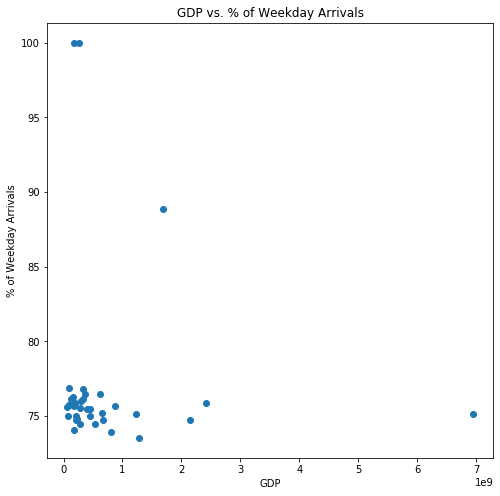

In [14]:
plt.figure(figsize=(8, 8))
plt.scatter(weekday_economics_PD['GDP'], weekday_economics_PD['% weekday'])
plt.title("GDP vs. % of Weekday Arrivals")
plt.xlabel("GDP")
plt.ylabel("% of Weekday Arrivals")
plt.show()

The District of Columbia, which includes Washington D.C., the center of US politics, has a much larger GDP per capita than all other states. Therefore, is removed to get a clearer picture.

Other outliers, such as South Carolina, Georgia and New Jersey are removed as well.

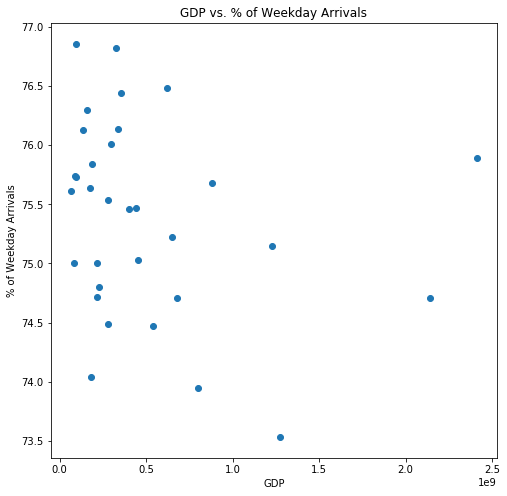

In [15]:
plt.figure(figsize=(8, 8))
plt.scatter(weekday_economics_PD[~weekday_economics_PD['Dest_state'].isin(["DC", 'SC', 'GA', 'NJ'])]['GDP'],\
            weekday_economics_PD[~weekday_economics_PD['Dest_state'].isin(["DC", 'SC', 'GA', 'NJ'])]['% weekday'])
plt.title("GDP vs. % of Weekday Arrivals")
plt.xlabel("GDP")
plt.ylabel("% of Weekday Arrivals")
plt.show()

From the plot above, we can determine that there does not appear to be a clear correlation between GDP and the percentage of flights that are on weekdays. Though counter-intuitive, this insight is still valuable, as it allows us to disconfirm our hypothesis.

## 2. Is there any relation between the business nature of a state and the proportion of flights that arrive early in the morning (e.g. with people in a business travel) with respect to the number of flights arriving during the rest of the day?

By answering this question, we may gain insight into the nature of travel for different sectors.

To begin, we must create a new binary column for early flights. For this, we will assume that early morning refers to flights that arrive after 4am and before 9am.

Once that is done, we must group the flights dataframe by state and compute the percentage of flights that are early.

Lastly, we merge this intermediate dataframe with the states dataframe, and create new columns representing the percentage of total for each of the various sectors.

**Note:** total here is not total GDP, but the total of the sectors included.

In [16]:
flightsDF = flightsDF.withColumn("early_arrival", F.when((F.col("ArrTime") >= 400) & (F.col("ArrTime") <= 900), 1)\
                                                   .otherwise(0)).cache()

early_ratio = flightsDF.where(F.col("ArrTime").isNotNull())\
                       .groupBy("Dest_state")\
                       .agg(F.round(F.mean("early_arrival") * 100, 2)\
                                     .alias("% early arrivals"))\
                       .withColumn("% rest of day", F.round((100 - F.col("% early arrivals")),2))\
                       .sort(F.col("% early arrivals").desc())

early_business_nature = early_ratio.join(statesDF, statesDF.STATE_CODE == early_ratio.Dest_state, how = 'left')\
                                   .withColumn("all_business",\
                                               (F.col("Agriculture") +\
                                                F.col("Services") +\
                                                F.col('Construction') +\
                                                F.col('Financial activities') +\
                                                F.col('Technology') +\
                                                F.col('Industry') +\
                                                F.col('Travelling and turism')))\
                                   .withColumn("% Agriculture",\
                                               F.round((F.col("Agriculture") / F.col("all_business"))*100, 2))\
                                   .withColumn("% Services",\
                                               F.round((F.col("Services") / F.col("all_business"))*100, 2))\
                                   .withColumn("% Construction",\
                                               F.round((F.col("Construction") / F.col("all_business"))*100, 2))\
                                   .withColumn("% Financial activities",\
                                               F.round((F.col("Financial activities") / F.col("all_business"))*100, 2))\
                                   .withColumn("% Technology",\
                                               F.round((F.col("Technology") / F.col("all_business"))*100, 2))\
                                   .withColumn("% Industry",\
                                               F.round((F.col("Industry") / F.col("all_business"))*100, 2))\
                                   .withColumn("% Travelling and tourism",\
                                               F.round((F.col("Travelling and turism") / F.col("all_business"))*100, 2))\
                                   .select("Dest_state",\
                                           "% Agriculture",\
                                           "% Services",\
                                           "% Construction",\
                                           "% Financial activities",\
                                           "% Technology",\
                                           "% Industry",\
                                           "% Travelling and tourism",\
                                           "GDP",\
                                           '% early arrivals',\
                                           '% rest of day')\
                                  .sort(F.col('% early arrivals').desc())

early_business_nature_PD = early_business_nature.toPandas()

In [17]:
early_business_nature_PD

,Dest_state,% Agriculture,% Services,% Construction,% Financial activities,% Technology,% Industry,% Travelling and tourism,GDP,% early arrivals,% rest of day
0,AL,1.66,12.87,4.90,58.41,1.23,15.73,5.20,182735392,16.44,83.56
1,LA,1.23,17.27,5.41,54.02,1.73,13.73,6.60,226555392,15.92,84.08
2,TN,2.01,16.40,5.35,50.27,2.02,17.28,6.66,188979635,14.90,85.10
3,NM,1.27,19.63,6.42,48.28,2.50,15.76,6.14,176201132,14.30,85.70
4,MO,1.46,12.03,4.08,63.59,1.61,11.84,5.39,155871570,13.11,86.89
5,IL,0.63,10.53,3.87,71.28,1.89,8.38,3.43,450830620,12.63,87.37
6,NV,0.43,16.61,3.21,58.25,2.48,13.79,5.22,539878844,11.75,88.25
7,NJ,0.25,12.85,4.15,61.77,2.78,12.69,5.51,1682092240,11.11,88.89
8,CA,0.28,10.54,2.27,68.69,1.63,11.24,5.36,2411658752,10.74,89.26
9,MD,0.85,11.60,4.37,65.01,2.23,11.21,4.73,878974371,10.47,89.53


Again, we have converted the Spark dataframe to a Pandas dataframe to plot.

The code below creates plots for each of the sectors versus early arrivals.

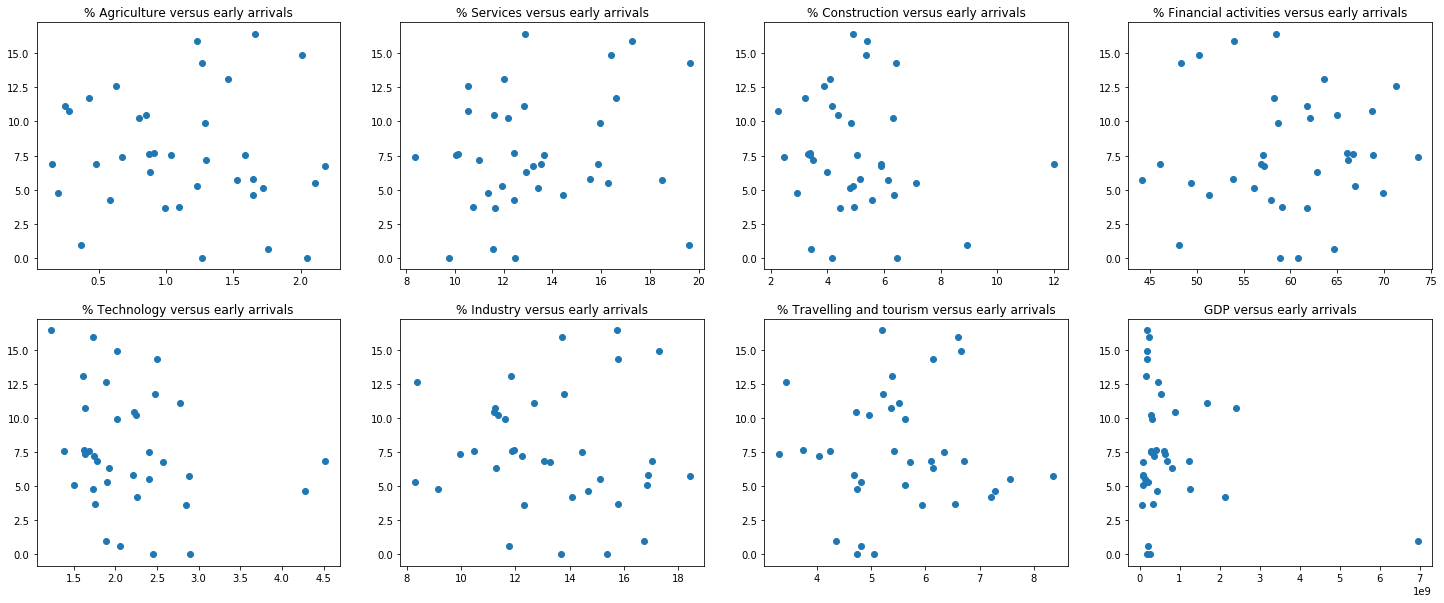

In [18]:
fig, axs = plt.subplots(2, 4, figsize = (25,10))

i = 0
j = 0

for col in early_business_nature_PD:
    if (col not in ["Dest_state", '% early arrivals', '% rest of day'] and i < 4):
        axs[j,i].scatter(early_business_nature_PD[col], early_business_nature_PD['% early arrivals'])
        axs[j,i].set_title(col + " versus early arrivals")
        i = i + 1
    elif col not in ["Dest_state", '% early arrivals', '% rest of day']:
        j = j + 1
        i = 0
        axs[j,i].scatter(early_business_nature_PD[col], early_business_nature_PD['% early arrivals'])
        axs[j,i].set_title(col + " versus early arrivals")
        i = i + 1
        

Though it appears that there is a positive relationship between Early Arrivals and Services, Travelling and Tourism, and Financial Activities, the relationships are not very pronounced. Thus, we can conclude that no clear relationships exist among the various industries and the percentage of early flights.

Similar to the previous insight, this analysis appears to disconfirm our hypothesis, which is valuable.

### 3. Is this proportion between flights arriving in the morning and the afternoon much different if we compare weekdays vs weekends in those states?

To answer this question, we establish new binary columns for morning and afternoon arivals. With this, we can group by destination and weekday/weekend to determine the percentage of arrivals that are morning and afternoon.

In [26]:
flightsDF = flightsDF.withColumn("morning_arrival", F.when(((F.col("ArrTime") >= 400) & (F.col("ArrTime") < 1200)), 1)\
                                                     .otherwise(0))\
                     .withColumn("afternoon_arrival", F.when(((F.col("ArrTime") >= 1200) & (F.col("ArrTime") <= 1700)), 1)\
                                                       .otherwise(0))\
                     .cache()

morn_aft_week = flightsDF.where((F.col("ArrTime").isNotNull() & (F.col("weekday") == 1)))\
                                  .groupBy("Dest_state")\
                                  .agg(F.round(F.mean("morning_arrival") * 100, 2)\
                                                .alias("weekday – % morning"),\
                                       F.round(F.mean("afternoon_arrival") * 100, 2)\
                                                .alias("weekday – % afternoon"))\
                                  .sort(F.col("Dest_state"))

morn_aft_weekend = flightsDF.where((F.col("ArrTime").isNotNull() & (F.col("weekday") == 0)))\
                                     .groupBy("Dest_state")\
                                     .agg(F.round(F.mean("morning_arrival") * 100, 2)\
                                                   .alias("weekend – % morning"),\
                                          F.round(F.mean("afternoon_arrival") * 100, 2)\
                                                   .alias("weekend – % afternoon"))\
                                     .sort(F.col("Dest_state"))\
                                     .withColumnRenamed("Dest_state", "dest")

morn_aft_full = morn_aft_week.join(morn_aft_weekend, morn_aft_week.Dest_state == morn_aft_weekend.dest, how = "full_outer")\
                             .withColumn("morning difference", (F.col("weekend – % morning") - F.col("weekday – % morning")))\
                             .withColumn("afternoon difference", (F.col("weekend – % afternoon") - F.col("weekday – % afternoon")))\
                             .select("Dest_state", "weekday – % morning", "weekend – % morning", "morning difference", "weekday – % afternoon", "weekend – % afternoon", "afternoon difference")\
                             .sort(F.col("morning difference"))


morn_aft_full_PD = morn_aft_full.toPandas()

In [27]:
morn_aft_full_PD.head(50)

,Dest_state,weekday – % morning,weekend – % morning,morning difference,weekday – % afternoon,weekend – % afternoon,afternoon difference
0,SC,0.00,NaN,NaN,100.00,NaN,NaN
1,GA,50.00,NaN,NaN,0.00,NaN,NaN
2,KY,27.82,16.79,-11.03,30.80,40.46,9.66
3,MO,31.15,22.24,-8.91,27.65,35.07,7.42
4,DC,21.65,12.99,-8.66,30.74,37.66,6.92
5,MD,28.84,21.56,-7.28,28.96,35.23,6.27
6,TX,29.44,22.29,-7.15,30.64,36.96,6.32
7,PA,28.64,21.64,-7.00,28.98,35.82,6.84
8,IN,17.85,11.02,-6.83,34.84,38.14,3.30
9,RI,24.53,17.72,-6.81,28.41,32.07,3.66


Looking at the morning difference column, we see that there is a substantial drop-off in the portion of flights that are in the morning from weekday to weekend. Conversely, there is a substantial rise in the ratio of afternoon flight, as per the afternoon difference column.

This result is in line with what can be expected. There is less business travel on weekends and less incentive to travel early in the morning. People are more likely to prefer travelling in the afternoon, as it would allow them to arrive and travel in a more leisurely manner.

### 4. Are there states that receive most flights at weekends? Is this typical of a vacation states?

The steps used to conduct the analysis are simlar to previous steps taken. Therefore, they will not be explained in detail. Insights drawn from this analysis can be seen at the bottom of this sections.

In [21]:
weekday_vacation = weekday_ratio.join(statesDF, statesDF.STATE_CODE == weekday_ratio.Dest_state, how = "left")\
                                .withColumn("all_business",\
                                            (F.col("Agriculture") +\
                                            F.col("Services") +\
                                            F.col('Construction') +\
                                            F.col('Financial activities') +\
                                            F.col('Technology') +\
                                            F.col('Industry') +\
                                            F.col('Travelling and turism')))\
                                .withColumn("% Travelling and tourism",\
                                               F.round((F.col("Travelling and turism") / F.col("all_business"))*100, 2))\
                                .select("Dest_state", "State", "Travelling and turism", "% Travelling and tourism", '% weekday', '% weekend')\
                                .sort(F.col("% weekend").desc())


weekday_vacation_PD = weekday_vacation.toPandas()

In [22]:
weekday_vacation_PD

,Dest_state,State,Travelling and turism,% Travelling and tourism,% weekday,% weekend
0,NY,New York,415801,4.75,73.53,26.47
1,FL,Florida,526622,6.15,73.95,26.05
2,AL,Alabama,116922,5.20,74.04,25.96
3,NV,Nevada,103815,5.22,74.47,25.53
4,CO,Colorado,213168,4.97,74.49,25.51
5,RI,Rhode Island,49389,6.71,74.71,25.29
6,CT,Connecticut,253183,7.22,74.71,25.29
7,VA,Virginia,202462,4.81,74.72,25.28
8,LA,Louisiana,169683,6.60,74.80,25.20
9,MS,Mississippi,112037,8.36,75.00,25.00


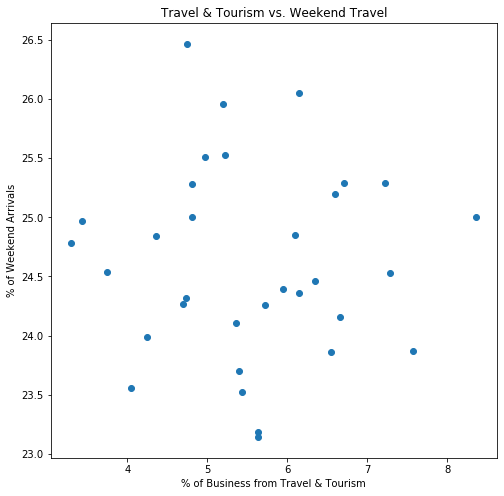

In [23]:
plt.figure(figsize=(8, 8))
plt.scatter(weekday_vacation_PD[~weekday_vacation_PD['Dest_state'].isin(['SC', 'GA', 'NJ'])]['% Travelling and tourism'],\
            weekday_vacation_PD[~weekday_vacation_PD['Dest_state'].isin(['SC', 'GA', 'NJ'])]['% weekend'])
plt.title("Travel & Tourism vs. Weekend Travel")
plt.xlabel("% of Business from Travel & Tourism")
plt.ylabel("% of Weekend Arrivals")
plt.show()

From the plot above, we see that there doesn't appear to be a correlation between the percentage of business that come from travel and tourism within a state, and the percentage of travel that is on weekends.

### 5. Can we say more developed states suffer from smaller arrival delays on average?

In [28]:
avg_delay = flightsDF.where(F.col("ArrDelay") > 0)\
                     .groupBy("Dest_state")\
                     .agg(F.round(F.mean("ArrDelay"),2)\
                            .alias("Avg arrival delay"))

delay_economics = statesDF.join(avg_delay, avg_delay.Dest_state == statesDF.STATE_CODE)\
                          .select('Dest_state',"State", "Avg arrival delay", 'GDP', 'GDP per capita')\
                          .sort(F.col("GDP").desc())

delay_economics_PD = delay_economics.toPandas()

In [29]:
delay_economics_PD

,Dest_state,State,Avg arrival delay,GDP,GDP per capita
0,DC,District of Columbia,27.94,6950033266,170687
1,CA,California,28.35,2411658752,54454
2,CT,Connecticut,30.78,2139102254,68777
3,NJ,New Jersey,33.50,1682092240,57784
4,NY,New York,25.44,1272836872,58532
5,AZ,Arizona,26.22,1228167600,41800
6,MD,Maryland,22.75,878974371,52877
7,FL,Florida,23.45,800281605,41241
8,RI,Rhode Island,25.26,677361022,45746
9,WA,Washington,27.35,648719712,54939


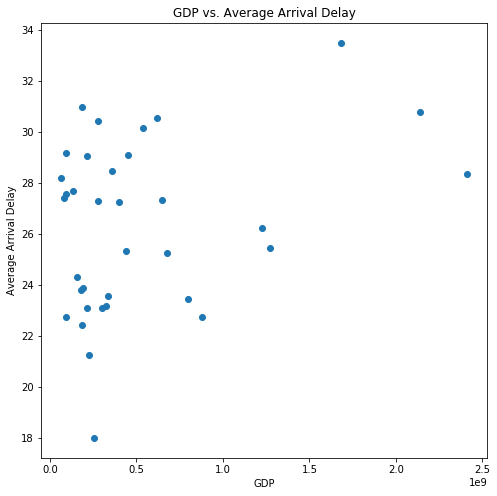

In [30]:
plt.figure(figsize=(8, 8))
plt.scatter(delay_economics_PD[~delay_economics_PD['Dest_state'].isin(['DC'])]['GDP'],\
            delay_economics_PD[~delay_economics_PD['Dest_state'].isin(['DC'])]['Avg arrival delay'])
plt.title("GDP vs. Average Arrival Delay")
plt.xlabel("GDP")
plt.ylabel("Average Arrival Delay")
plt.show()

From the analysis done above, it appears that as GDP increases, so too does the average arrival delay. Though additional qualitative analysis should be done to understand the nature of this relationship, it's likley a product of a higher demand for travel to cities with higher GDP, which increases the complexity of air traffic control and travel in general.

### 6. Is there a relation between the arrival time and the arrival delay? Is the relation the same for all categories of states?

In [36]:
flightsDF = flightsDF.where(F.col("ArrTime").isNotNull())\
                     .withColumn("ArrDayPart", when((F.col('ArrTime') >= 600) & (F.col('ArrTime') <= 1200), "morning")\
                                              .when((F.col('ArrTime') > 1200) & (F.col('ArrTime') <= 1700), 'afternoon')\
                                              .when((F.col('ArrTime') > 1700) & (F.col('ArrTime') <= 2000), 'evening')\
                                              .otherwise('night')).cache()

arr_delay_dayPart = flightsDF.where(F.col("ArrDelay") > 0)\
                             .groupBy("ArrDayPart")\
                             .agg(F.round(F.mean(F.col("ArrDelay")), 2).alias("Avg Arrival Delay"))\
                             .sort(F.col("Avg Arrival Delay").desc())

arr_delay_dayPart.show()

+----------+-----------------+
|ArrDayPart|Avg Arrival Delay|
+----------+-----------------+
|     night|            42.44|
|   evening|             26.8|
| afternoon|            21.27|
|   morning|            12.63|
+----------+-----------------+



In [38]:
flights_sample_PD = flightsDF.where(F.col("ArrTime").isNotNull()).where(F.col("ArrDelay") > 0).sample(False, 0.1, seed=0).toPandas()

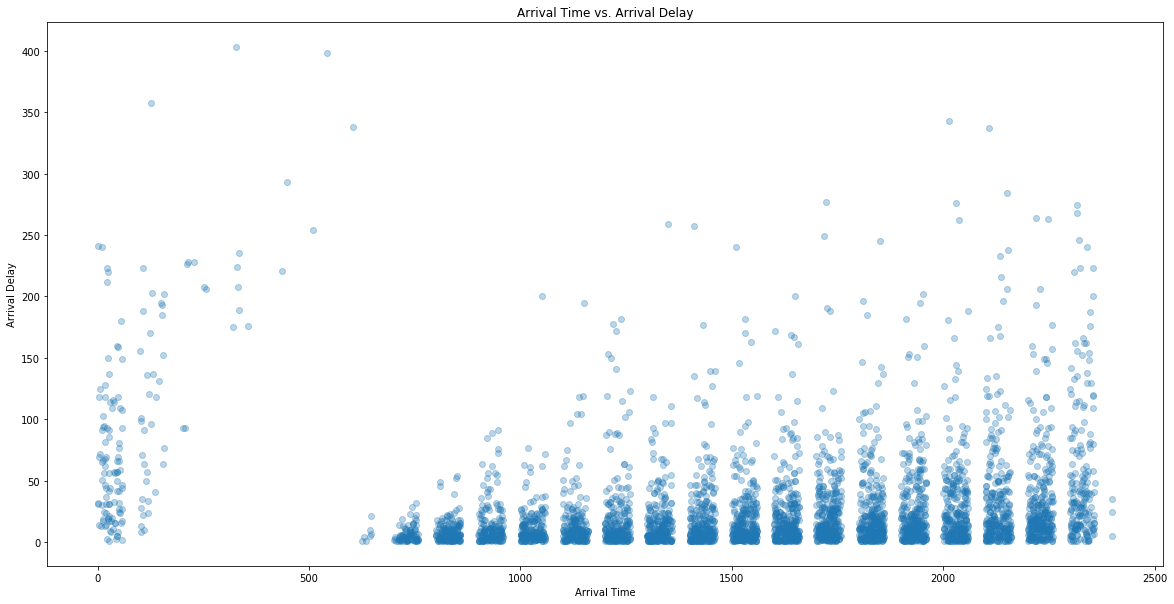

In [39]:
plt.figure(figsize=(20, 10))
plt.scatter(flights_sample_PD['ArrTime'], flights_sample_PD['ArrDelay'], alpha = 0.3)
plt.title("Arrival Time vs. Arrival Delay")
plt.xlabel("Arrival Time")
plt.ylabel("Arrival Delay")
plt.show()

We see that the average delay is much longer at night and lower in the morning at 42.44 and 12.63 minutes, respectively. From the scatter plot above, we see that arrival delays increase as the day goes on.

### 7. Is there a relation between the departure time and the departure delay? Is the relation the same for all categories of states?

In [40]:
flightsDF = flightsDF.where(F.col("DepTime").isNotNull())\
                     .withColumn("DepDayPart", when((F.col('DepTime') >= 600) & (F.col('DepTime') <= 1200), "morning")\
                                              .when((F.col('DepTime') > 1200) & (F.col('DepTime') <= 1700), 'afternoon')\
                                              .when((F.col('DepTime') > 1700) & (F.col('DepTime') <= 2000), 'evening')\
                                              .otherwise('night')).cache()

dep_delay_dayPart = flightsDF.where(F.col("DepDelay") > 0)\
                             .groupBy("DepDayPart")\
                             .agg(F.round(F.mean(F.col("DepDelay")), 2).alias("Avg Departure Delay"))\
                             .sort(F.col("Avg Departure Delay").desc())

dep_delay_dayPart.show()

+----------+-------------------+
|DepDayPart|Avg Departure Delay|
+----------+-------------------+
|     night|              48.74|
|   evening|              26.17|
| afternoon|              19.92|
|   morning|               11.4|
+----------+-------------------+



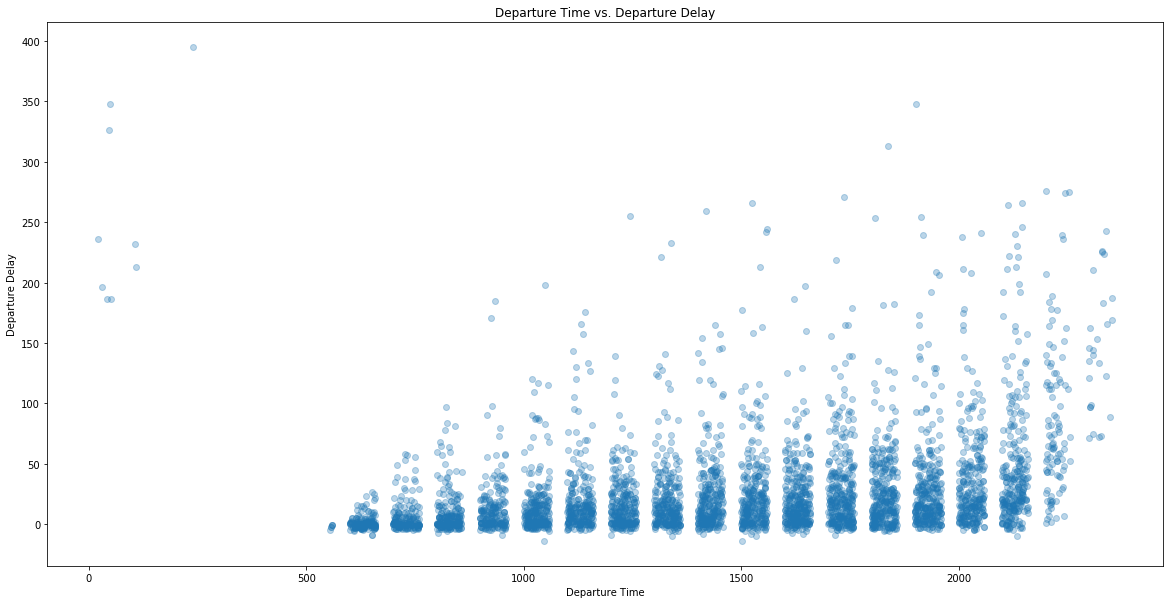

In [41]:
plt.figure(figsize=(20, 10))
plt.scatter(flights_sample_PD['DepTime'], flights_sample_PD['DepDelay'], alpha = 0.3)
plt.title("Departure Time vs. Departure Delay")
plt.xlabel("Departure Time")
plt.ylabel("Departure Delay")
plt.show()

We see that departure delays are low in the mornings and they rise throughout the day. This understandable, as issues that lead to delay can compound throughout the day.

# Conclusion

From the above analysis, we saw some very interesting relationships between state-level economics and airport behavior. Though additional qualitative analysis should be conducted to further understand the nature of the relationships (or lack thereof) that have been discovered, this preliminary analysis can be very useful for government and airport decision-makers in order to optimize factors that are relevant to them.